In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
import lightgbm as lgb
import joblib  # For saving models
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def train_discriminator_with_importance(csv_path, model_path, target_name, n_folds=5):
    # Step 1: Load data
    df = pd.read_csv(csv_path)
    feature_cols = [col for col in df.columns if col.startswith('bit_')]  # ECFP4 bits
    y = df['active_label'].values
    X = df[feature_cols].values
    print(f"Loaded {target_name} data: {len(df)} samples, {np.sum(y)} actives, {len(y) - np.sum(y)} inactives")

    # Step 2: K-fold cross-validation
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_metrics = []
    all_y_test = []
    all_y_pred_prob = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\nFold {fold+1}/{n_folds}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

        params = {
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.1,
            'num_leaves': 31,
            'max_depth': -1,
            'min_data_in_leaf': 20,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'is_unbalance': True,  # Handle class imbalance
            'verbose': -1,
            'seed': 42
        }

        model = lgb.train(
            params,
            train_data,
            num_boost_round=2000,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
        )

        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

        metrics = {
            'auc': roc_auc_score(y_test, y_pred_prob),
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
        fold_metrics.append(metrics)

        all_y_test.extend(y_test)
        all_y_pred_prob.extend(y_pred_prob)

        print(f"Fold AUC: {metrics['auc']:.4f}, Acc: {metrics['accuracy']:.4f}, "
              f"Prec: {metrics['precision']:.4f}, Rec: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

    # Step 3: Average metrics
    avg = {k: np.mean([m[k] for m in fold_metrics]) for k in fold_metrics[0]}
    print(f"\n=== {target_name} CV Results ===")
    for k, v in avg.items():
        print(f"{k.capitalize():9}: {v:.4f}")

    # Step 4: Visualizations
    # Confusion Matrix
    cm = confusion_matrix(all_y_test, (np.array(all_y_pred_prob) > 0.5).astype(int))
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{target_name} - Confusion Matrix (Aggregated)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{target_name}_Confusion_Matrix.jpg') # Save before show
    plt.show()
    plt.close() # Close the figure

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_y_test, all_y_pred_prob)
    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, label=f'AUC = {avg["auc"]:.4f}', color='darkorange')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{target_name} - ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{target_name}_ROC_Curve.jpg') # Save before show
    plt.show()
    plt.close() # Close the figure

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_y_test, all_y_pred_prob)
    plt.figure(figsize=(7,6))
    plt.plot(recall, precision, label=f'PR AUC = {np.trapz(precision, recall):.4f}', color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{target_name} - Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{target_name}_Precision_Recall_Curve.jpg') # Save before show
    plt.show()
    plt.close() # Close the figure

    # Step 5: Retrain on full dataset
    full_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(
        params,
        full_data,
        num_boost_round=2000
    )

    # Step 6: Feature Importance Plot
    importance = final_model.feature_importance(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
    plt.title(f'{target_name} - Top 20 Important ECFP4 Bits (Gain)')
    plt.xlabel('Importance (Total Gain)')
    plt.ylabel('ECFP4 Bit Index')
    plt.tight_layout()
    plt.savefig(f'{target_name}_Top_20_Important_ECFP4_Bits.jpg') # Save before show
    plt.show()
    plt.close() # Close the figure

    # Save model
    final_model.save_model(model_path + '.txt')  # LightGBM format
    print(f"\nFinal model saved to {model_path}.txt")
    joblib.dump(final_model, model_path + '.pkl')  # For easy loading
    print(f"{target_name} model saved to {model_path}")

Loaded MET data: 1109 samples, 928.0 actives, 181.0 inactives

Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's auc: 0.973119
Fold AUC: 0.9731, Acc: 0.9414, Prec: 0.9574, Rec: 0.9730, F1: 0.9651

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.977001
Fold AUC: 0.9770, Acc: 0.9414, Prec: 0.9529, Rec: 0.9785, F1: 0.9655

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.983274
Fold AUC: 0.9833, Acc: 0.9550, Prec: 0.9681, Rec: 0.9785, F1: 0.9733

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.974761
Fold AUC: 0.9748, Acc: 0.9595, Prec: 0.9683, Rec: 0.9839, F1: 0.9760

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	vali

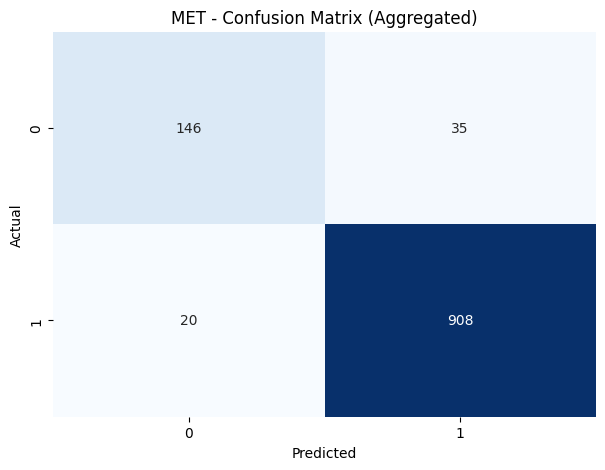

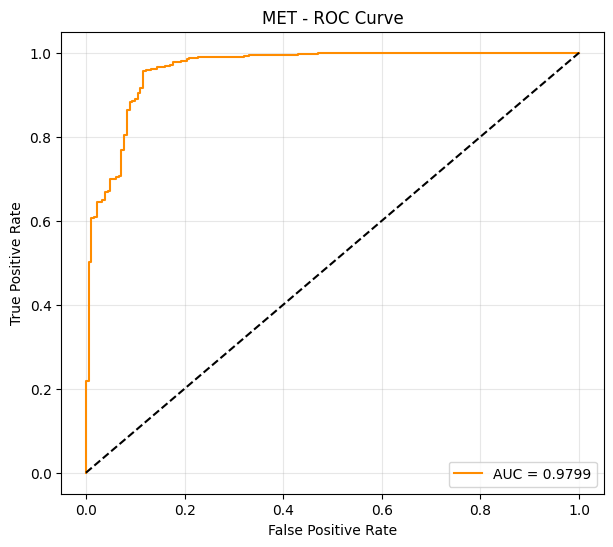

/tmp/ipython-input-2685588766.py:99: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(recall, precision, label=f'PR AUC = {np.trapz(precision, recall):.4f}', color='green')


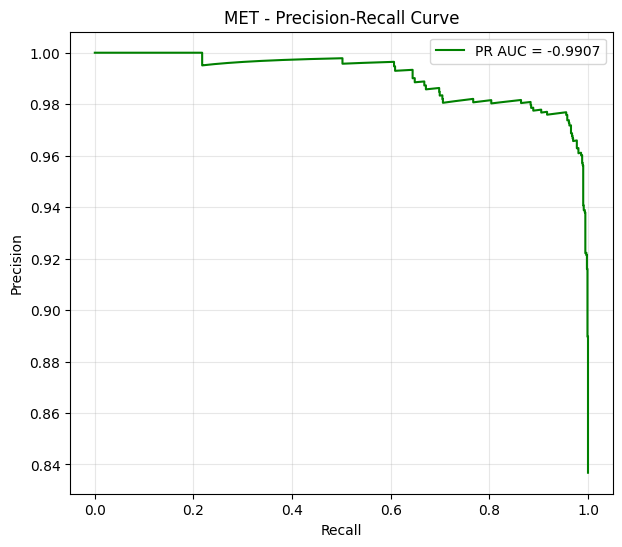

/tmp/ipython-input-2685588766.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


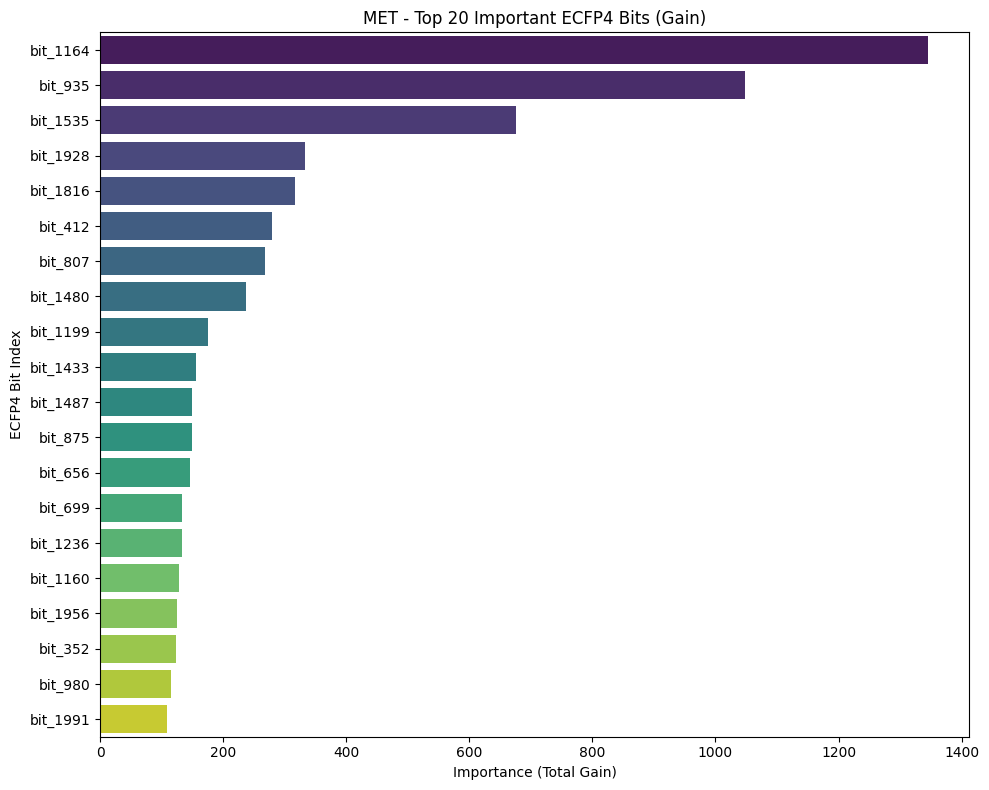


Final model saved to MET_discriminator.txt
MET model saved to MET_discriminator


In [4]:
# === RUN FOR MET ===
train_discriminator_with_importance('/content/MET_qsar_training_data.csv', 'MET_discriminator', 'MET')